# Utah COVID-19 Modified SIR Model Updated

The SIR model (susceptible, infected, recovered) is one way to predict the infection and recovery rates for a disease that is readily communicable in a large population. In this implementation, a portion of the infected will go to the hospital (H) and some in the hospital will die (D) and some will recover (R). The total number of people is constant S+I+R+H+D = N. Clint Guymon April 15; updated July 2, 2020.<br> 
\begin{align}
S\longrightarrow & I \longrightarrow R\\
& I \longrightarrow H \longrightarrow D\\
& H\longrightarrow R\\
\end{align}

## Updated Summary and Conclusions

***Conclusion:COVID-19 Death Rate in Utah is 0.2-0.5%.*** About 2-5 times as deadly as the flu (0.1% death rate). In Utah today, 176 people have died and 23270 confirmed cases (I say at least double that amount have been infected) which is a 0.4% death rate. Previous estimates were more than 10 times that rate so results were way too conservative. Below are further conclusions. 

Additional insights
- Societal efforts have saved lives, approximately >1,000 in Utah by the time this is all over
- Without social distancing and quarantine efforts, >2,000 people would have died in Utah.
- Closing businesses again will likely result in significant economic costs and relatively a minor reduction in the number of lives saved in Utah (~260).
- Continued efforts to reduce the spread of the virus should be followed.

Details are below. The RO value is essentially the number of people that an infected person then infects. Based on the limited initial data from the last 4 weeks, the RO value has gone down from approximately 3 to 1 or so and then has increased to 1.2 approximately after the state went to yellow. I expect that we'll be through the peak in 2 months (near the end of August).

Data for the existing infections, hospitalizations, and deaths are from the Utah government at https://coronavirus.utah.gov/case-counts/. Note that the below estimates are very rough as there are so many unknowns regarding the behavior of the virus with respect to infection rates and other critcal variables. For example, in Iceland, it has been reported that approximately 50% of people that are infected have no symptoms and that the current testing results in up to a 30% false negative rate (people have the disease but are told they don't).

## Necessary functions to determine each group as a function of time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#first and second derivatives
class derivatives():
    def dS(var):
        return -var['beta']*var['S'][-1]*var['I'][-1]/var['N']
    def dI(var):
        return var['beta']*var['S'][-1]*var['I'][-1]/var['N']-var['gamma_h']*var['I'][-1]-var['gamma_r']*var['I'][-1]
    def dH(var):
        return var['gamma_h']*var['I'][-1]-var['delta_d']*var['H'][-1]-var['delta_r']*var['H'][-1]
    def dR(var):
        return var['gamma_r']*var['I'][-1]+var['delta_r']*var['H'][-1]
    def dD(var):
        return var['delta_d']*var['H'][-1]
    def d2S(var):
        return -var['beta']*var['S'][-1]/var['N']*derivatives.dI(var)-var['beta']*var['I'][-1]/var['N']*derivatives.dS(var)
    def d2I(var):
        return -derivatives.d2S(var)-var['gamma_h']*derivatives.dI(var)-var['gamma_r']*derivatives.dI(var)
    def d2H(var):
        return var['gamma_h']*derivatives.dI(var)-var['delta_d']*derivatives.dH(var)-var['delta_r']*derivatives.dH(var)
    def d2R(var):
        return var['gamma_r']*derivatives.dI(var) + var['delta_r']*derivatives.dH(var)
    def d2D(var):
        return var['delta_d']*derivatives.dH(var)

In [3]:
#Truncated Taylor series used to integrate and determine the values which is not the most efficient method but 
# provided the time step is sufficiently small, which it is, the outcomes are accurate
def simulate(N=3.2e6,Io=29,steps=4e4,tstep=0.01,transitions={'Day0,RO4':[0,4],'Day10,RO3':[10,3]},
             gamma_h=0.012,gamma_r=0.15,delta_r=0.02,delta_d=0.015,):
    var = {'time':[0],'S':[N],'I':[Io],'R':[0],'H':[0],'D':[0],
           'beta':(gamma_h+gamma_r),'gamma_h':gamma_h,'gamma_r':gamma_r,'delta_r':delta_r,'delta_d':delta_d,'N':N}
    nohospitalbeds=5000
    for i in range(steps):
        for each in var:
            if type(var[each])==type([]):
                for tran in transitions:
                    if i*tstep>=transitions[tran][0]:
                        var['beta'] = transitions[tran][1]*(var['gamma_h']+var['gamma_r'])
                    if var['H'][-1]>nohospitalbeds:
                        var['delta_d']=delta_d*10
                    else:
                        var['delta_d']=delta_d
                if each!='time':
                    fderiv = getattr(derivatives,'d'+str(each))
                    sderiv = getattr(derivatives,'d2'+str(each))
                    var[each].append(var[each][-1]+fderiv(var)*tstep+0.5*sderiv(var)*tstep**2)
                else:
                    var[each].append(var[each][-1]+tstep)
    dataframe = pd.DataFrame(dict((k, var[k]) for k in ('time','S', 'I', 'R', 'H', 'D')))
    return dataframe.set_index('time')

In [4]:
#data to June 30, 2020
data=pd.read_csv('jupyterfiles/utahcovid.csv')

In [5]:
def covidplt(df,withdata=True):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    plt.grid()
    if withdata:
        offset=23
        ax.scatter(data.index+offset,data['Infected'],color='orange',marker='.')
        ax.scatter(data.index+offset,data['Hospitalized'],color='maroon',marker='.') #day 27 is on Apr. 14, 2020, day 44 is May 1
        ax.scatter(data.index+offset,data['Dead'],color='purple',marker='.')
    ax.semilogy(df.index,df['S'],label='susceptible');ax.plot(df.index,df['I'],label='infected')
    ax.plot(df.index,df['R'],label='recovered');ax.plot(df.index,df['H'],label='hospitalized')
    ax.plot(df.index,df['D'],label='deceased')
    plt.xlabel('days');plt.ylabel('No of People in Utah')
    plt.ylim(1,3.5e6);plt.legend(loc='upper right')
    plt.show()

In [6]:
So=3.2e6/3

## Scenario 1: No social distancing or other efforts to prevent the spread of COVID

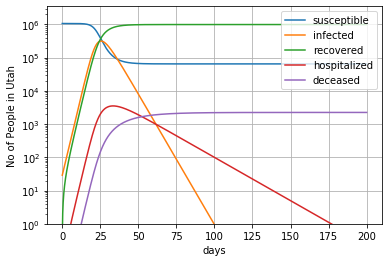

In [7]:
df1=simulate(N=So,Io=29,steps=4000,tstep=0.05,transitions={'Day0,RO3':[0,3]},
            gamma_h=0.0015,gamma_r=0.22,delta_r=0.04,delta_d=0.02)
covidplt(df1,withdata=False)

In [8]:
df1.iloc[df1.index.get_loc(200,method='nearest')]

S    6.490497e+04
I    1.293477e-08
R    9.930922e+05
H    2.475604e-01
D    2.246733e+03
Name: 200.00000000001123, dtype: float64

#### **No. of People dead: 2,200: 0.22% death rate**  <br>
**Almost 1 million people infected**

## Scenario 2: Current Efforts

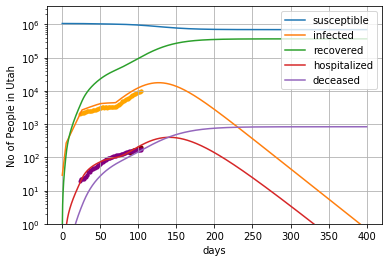

In [9]:
df2=simulate(N=So,Io=29,steps=8000,tstep=0.05,transitions={'Day0,RO4':[0,3],'Day26,RO2':[5,1.5],'Day26,RO11':[26,1.1],
                                                                'Day50,RO1':[50,1.05],'Day70,RO117':[70,1.24]},
            gamma_h=0.0015,gamma_r=0.22,delta_r=0.04,delta_d=0.02)
covidplt(df2)

In [10]:
df2.iloc[df2.index.get_loc(400,method='nearest')]

S    697654.285718
I         0.690057
R    368153.569638
H         0.056190
D       832.908039
Name: 400.0000000000567, dtype: float64

**No. of People dead: 832: 0.23% death rate**  <br>
**368,000 people infected**<br>

Comparing to Scenario 1: **1,370 lives saved from societal efforts**

## Scenario 3: Businesses shut down again with manditory social distancing

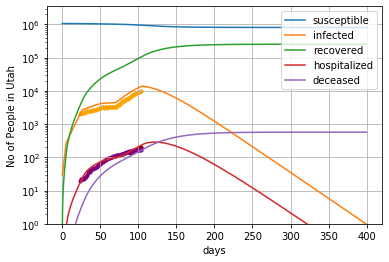

In [11]:
df3=simulate(N=So,Io=29,steps=8000,tstep=0.05,transitions={'Day0,RO4':[0,3],'Day26,RO2':[5,1.5],'Day26,RO11':[26,1.1],
                                                                'Day50,RO1':[50,1.05],'Day70,RO117':[70,1.24],'Day100,RO11':[105,1.1]},
            gamma_h=0.0015,gamma_r=0.22,delta_r=0.04,delta_d=0.02)
covidplt(df3)

In [12]:
df3.iloc[df3.index.get_loc(400,method='nearest')]

S    812462.349453
I         0.966416
R    253633.844352
H         0.059939
D       573.812398
Name: 400.0000000000567, dtype: float64

**No. of People dead: 573: 0.23% death rate**  <br>
**Over 253,000 people infected**<br>

Compared to Scenario 2, 260 fewer peope die.